<a href="https://colab.research.google.com/github/wootaehyeon/AI_lab/blob/main/AI_week5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [29]:
#tacotron 가능한 버전
#wav 끝까지 실행
#tts 영어 자기소개

In [30]:
import torch
import torchaudio

torch.random.manual_seed(0)
device = "cuda" if torch.cuda.is_available() else "cpu"

print(torch.__version__)
print(torchaudio.__version__)
print(device)

2.8.0+cu126
2.8.0+cu126
cpu


In [31]:
import IPython
import matplotlib.pyplot as plt

In [32]:
symbols = "_-!'(),.:;? abcdefghijklmnopqrstuvwxyz"
look_up = {s: i for i, s in enumerate(symbols)}
symbols = set(symbols)


def text_to_sequence(text):
    text = text.lower()
    return [look_up[s] for s in text if s in symbols]


text = "Hello world! Text to speech!"
print(text_to_sequence(text))

[19, 16, 23, 23, 26, 11, 34, 26, 29, 23, 15, 2, 11, 31, 16, 35, 31, 11, 31, 26, 11, 30, 27, 16, 16, 14, 19, 2]


In [33]:
processor = torchaudio.pipelines.TACOTRON2_WAVERNN_CHAR_LJSPEECH.get_text_processor()

text = "HIIIII myyyyy name isssssssssssss"
processed, lengths = processor(text)

print(processed)
print(lengths)

tensor([[19, 20, 20, 20, 20, 20, 11, 24, 36, 36, 36, 36, 36, 11, 25, 12, 24, 16,
         11, 20, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30]])
tensor([33], dtype=torch.int32)


In [34]:
print([processor.tokens[i] for i in processed[0, : lengths[0]]])

['h', 'i', 'i', 'i', 'i', 'i', ' ', 'm', 'y', 'y', 'y', 'y', 'y', ' ', 'n', 'a', 'm', 'e', ' ', 'i', 's', 's', 's', 's', 's', 's', 's', 's', 's', 's', 's', 's', 's']


In [35]:
# Use character-based version instead of phone-based
bundle = torchaudio.pipelines.TACOTRON2_WAVERNN_CHAR_LJSPEECH  # CHAR instead of PHONE

processor = bundle.get_text_processor()

text = "Hello world! Text to speech!"
with torch.inference_mode():
    processed, lengths = processor(text)

print("✓ Character-based processing works!")
print(processed)
print(lengths)

✓ Character-based processing works!
tensor([[19, 16, 23, 23, 26, 11, 34, 26, 29, 23, 15,  2, 11, 31, 16, 35, 31, 11,
         31, 26, 11, 30, 27, 16, 16, 14, 19,  2]])
tensor([28], dtype=torch.int32)


In [36]:

print([processor.tokens[i] for i in processed[0, : lengths[0]]])

['h', 'e', 'l', 'l', 'o', ' ', 'w', 'o', 'r', 'l', 'd', '!', ' ', 't', 'e', 'x', 't', ' ', 't', 'o', ' ', 's', 'p', 'e', 'e', 'c', 'h', '!']


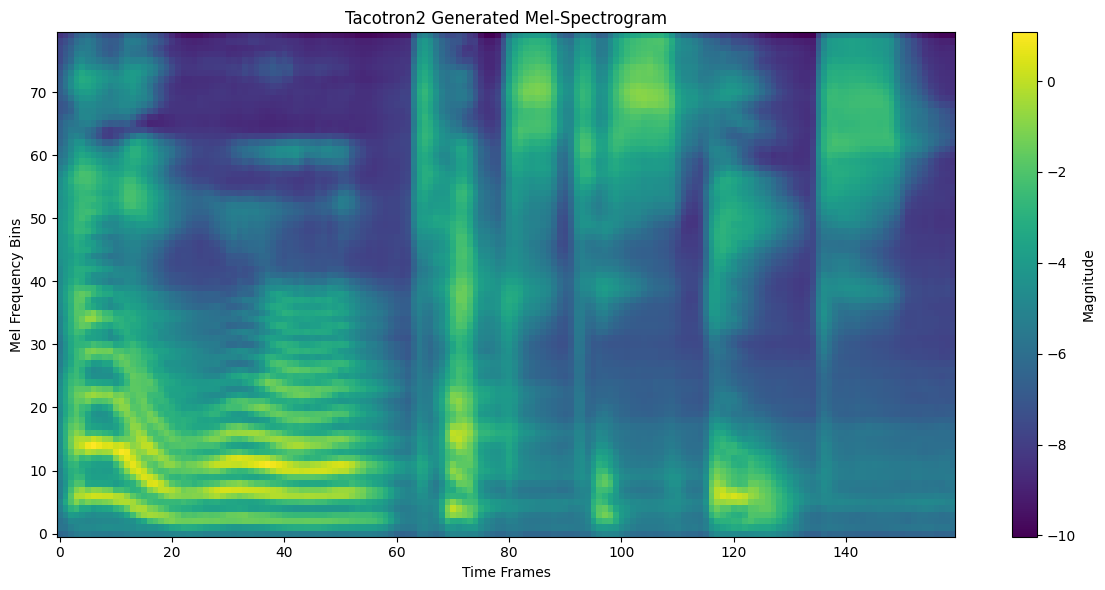

✓ Generated spectrogram shape: torch.Size([1, 80, 160])
✓ Text: 'Hello world! Text to speech!'


In [37]:
# Use character-based version instead of phone-based
bundle = torchaudio.pipelines.TACOTRON2_WAVERNN_CHAR_LJSPEECH  # CHAR instead of PHONE
processor = bundle.get_text_processor()
tacotron2 = bundle.get_tacotron2().to(device)

text = "Hello world! Text to speech!"

with torch.inference_mode():
    processed, lengths = processor(text)
    processed = processed.to(device)
    lengths = lengths.to(device)
    spec, _, _ = tacotron2.infer(processed, lengths)

# Add colorbar and better visualization
plt.figure(figsize=(12, 6))
im = plt.imshow(spec[0].cpu().detach(), origin="lower", aspect="auto", interpolation="nearest")
plt.colorbar(im, label='Magnitude')
plt.title('Tacotron2 Generated Mel-Spectrogram')
plt.xlabel('Time Frames')
plt.ylabel('Mel Frequency Bins')
plt.tight_layout()
plt.show()

print(f"✓ Generated spectrogram shape: {spec.shape}")
print(f"✓ Text: '{text}'")

torch.Size([80, 189])
torch.Size([80, 179])
torch.Size([80, 180])


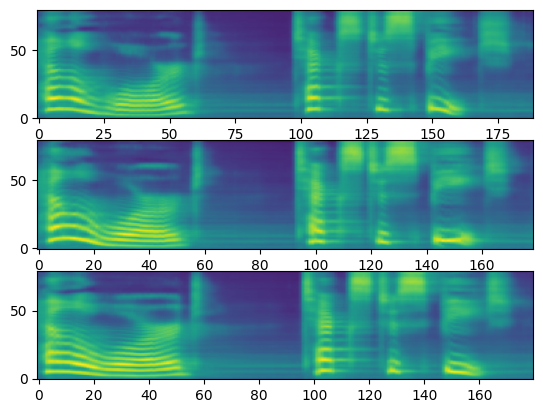

In [38]:
def plot():
    fig, ax = plt.subplots(3, 1)
    for i in range(3):
        with torch.inference_mode():
            spec, spec_lengths, _ = tacotron2.infer(processed, lengths)
        print(spec[0].shape)
        ax[i].imshow(spec[0].cpu().detach(), origin="lower", aspect="auto")


plot()

In [ ]:
# Use character-based version instead of phone-based for waveform generation
bundle = torchaudio.pipelines.TACOTRON2_WAVERNN_CHAR_LJSPEECH  # CHAR instead of PHONE

processor = bundle.get_text_processor()
tacotron2 = bundle.get_tacotron2().to(device)
vocoder = bundle.get_vocoder().to(device)

text = "HIIIII myyyyy name isssssssssssss"

with torch.inference_mode():
    processed, lengths = processor(text)
    processed = processed.to(device)
    lengths = lengths.to(device)
    spec, spec_lengths, _ = tacotron2.infer(processed, lengths)
    waveforms, lengths = vocoder(spec, spec_lengths)

print(f"✓ Generated waveform shape: {waveforms.shape}")
print(f"✓ Waveform lengths: {lengths}")
print(f"✓ Text: '{text}'")

# Use vocoder.sample_rate instead of bundle.sample_rate
print(f"✓ Sample rate: {vocoder.sample_rate} Hz")

# Play the generated audio
torchaudio.save("generated_speech.wav", waveforms[0:1].cpu(), sample_rate=vocoder.sample_rate)
IPython.display.Audio(waveforms[0:1].cpu().numpy(), rate=vocoder.sample_rate)

In [ ]:
def plot(waveforms, spec, sample_rate):
    waveforms = waveforms.cpu().detach()

    fig, [ax1, ax2] = plt.subplots(2, 1)
    ax1.plot(waveforms[0])
    ax1.set_xlim(0, waveforms.size(-1))
    ax1.grid(True)
    ax2.imshow(spec[0].cpu().detach(), origin="lower", aspect="auto")
    return IPython.display.Audio(waveforms[0:1], rate=sample_rate)


plot(waveforms, spec, vocoder.sample_rate)


In [ ]:
# Workaround to load model mapped on GPU
# https://stackoverflow.com/a/61840832
waveglow = torch.hub.load(
    "NVIDIA/DeepLearningExamples:torchhub",
    "nvidia_waveglow",
    model_math="fp32",
    pretrained=False,
)
checkpoint = torch.hub.load_state_dict_from_url(
    "https://api.ngc.nvidia.com/v2/models/nvidia/waveglowpyt_fp32/versions/1/files/nvidia_waveglowpyt_fp32_20190306.pth",  # noqa: E501
    progress=False,
    map_location=device,
)
state_dict = {key.replace("module.", ""): value for key, value in checkpoint["state_dict"].items()}

waveglow.load_state_dict(state_dict)
waveglow = waveglow.remove_weightnorm(waveglow)
waveglow = waveglow.to(device)
waveglow.eval()

with torch.no_grad():
    waveforms = waveglow.infer(spec)

In [ ]:
def plot():
    fig, ax = plt.subplots(3, 1)
    for i in range(3):
        with torch.inference_mode():
            spec, spec_lengths, _ = tacotron2.infer(processed, lengths)
        print(spec[0].shape)
        ax[i].imshow(spec[0].cpu().detach(), origin="lower", aspect="auto")


plot()

In [28]:
bundle = torchaudio.pipelines.TACOTRON2_WAVERNN_PHONE_LJSPEECH

processor = bundle.get_text_processor()
tacotron2 = bundle.get_tacotron2().to(device)
vocoder = bundle.get_vocoder().to(device)

text = "Hello world! Text to speech!"

with torch.inference_mode():
    processed, lengths = processor(text)
    processed = processed.to(device)
    lengths = lengths.to(device)
    spec, spec_lengths, _ = tacotron2.infer(processed, lengths)
    waveforms, lengths = vocoder(spec, spec_lengths)

RuntimeError: DeepPhonemizer is not installed. Please install it.

In [ ]:
def plot(waveforms, spec, sample_rate):
    waveforms = waveforms.cpu().detach()

    fig, [ax1, ax2] = plt.subplots(2, 1)
    ax1.plot(waveforms[0])
    ax1.set_xlim(0, waveforms.size(-1))
    ax1.grid(True)
    ax2.imshow(spec[0].cpu().detach(), origin="lower", aspect="auto")
    return IPython.display.Audio(waveforms[0:1], rate=sample_rate)


plot(waveforms, spec, vocoder.sample_rate)

In [ ]:
bundle = torchaudio.pipelines.TACOTRON2_GRIFFINLIM_PHONE_LJSPEECH

processor = bundle.get_text_processor()
tacotron2 = bundle.get_tacotron2().to(device)
vocoder = bundle.get_vocoder().to(device)

with torch.inference_mode():
    processed, lengths = processor(text)
    processed = processed.to(device)
    lengths = lengths.to(device)
    spec, spec_lengths, _ = tacotron2.infer(processed, lengths)
waveforms, lengths = vocoder(spec, spec_lengths)

In [ ]:
plot(waveforms, spec, vocoder.sample_rate)

In [ ]:
# Workaround to load model mapped on GPU
# https://stackoverflow.com/a/61840832
waveglow = torch.hub.load(
    "NVIDIA/DeepLearningExamples:torchhub",
    "nvidia_waveglow",
    model_math="fp32",
    pretrained=False,
)
checkpoint = torch.hub.load_state_dict_from_url(
    "https://api.ngc.nvidia.com/v2/models/nvidia/waveglowpyt_fp32/versions/1/files/nvidia_waveglowpyt_fp32_20190306.pth",  # noqa: E501
    progress=False,
    map_location=device,
)
state_dict = {key.replace("module.", ""): value for key, value in checkpoint["state_dict"].items()}

waveglow.load_state_dict(state_dict)
waveglow = waveglow.remove_weightnorm(waveglow)
waveglow = waveglow.to(device)
waveglow.eval()

with torch.no_grad():
    waveforms = waveglow.infer(spec)

In [ ]:
plot(waveforms, spec, 22050)